# Mamogram classification

We'll be using the "mammographic masses" public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:


   1. BI-RADS assessment: 1 to 5 (ordinal)  
   2. Age: patient's age in years (integer)
   3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
   4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
   5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
   6. Severity: benign=0 or malignant=1 (binominal)
   
BI-RADS is an assesment of how confident the severity classification is; it is not a "predictive" attribute and so we will discard it. The age, shape, margin, and density attributes are the features that we will build our model with, and "severity" is the classification we will attempt to predict based on those attributes.

Although "shape" and "margin" are nominal data types, which sklearn typically doesn't deal with well, they are close enough to ordinal that we shouldn't just discard them. The "shape" for example is ordered increasingly from round to irregular.

A lot of unnecessary anguish and surgery arises from false positives arising from mammogram results. If we can build a better way to interpret them through supervised machine learning, it could improve a lot of lives.

--- 

# Let's begin by preparing the data.

We are importing the mammoraphic_masses.data.txt file into data frame and cleaning it.

In [4]:
import pandas as pd

masses_data = pd.read_csv('data/mammographic_masses.data.txt', na_values=['?'], names = ['BI-RADS', 'age', 'shape', 'margin', 'density', 'severity'])
masses_data.head()

,BI-RADS,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


In [5]:
masses_data.describe()

,BI-RADS,age,shape,margin,density,severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


There are quite a few missing values in the data set. Before we just drop every row that's missing data, let's make sure we don't bias our data in doing so. Does there appear to be any sort of correlation to what sort of data has missing fields? If there were, we'd have to try and go back and fill that data in.

In [6]:
masses_data.loc[(masses_data['age'].isnull()) |
              (masses_data['shape'].isnull()) |
              (masses_data['margin'].isnull()) |
              (masses_data['density'].isnull())]

,BI-RADS,age,shape,margin,density,severity
1,4.0,43.0,1.0,1.0,NaN,1
4,5.0,74.0,1.0,5.0,NaN,1
5,4.0,65.0,1.0,NaN,3.0,0
6,4.0,70.0,NaN,NaN,3.0,0
7,5.0,42.0,1.0,NaN,3.0,0
...,...,...,...,...,...,...
778,4.0,60.0,NaN,4.0,3.0,0
819,4.0,35.0,3.0,NaN,2.0,0
824,6.0,40.0,NaN,3.0,4.0,1
884,5.0,NaN,4.0,4.0,3.0,1


If the missing data seems randomly distributed, go ahead and drop rows with missing data. Hint: use dropna().

In [7]:
masses_data.dropna(inplace=True)
masses_data.describe()

,BI-RADS,age,shape,margin,density,severity
count,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,4.393976,55.781928,2.781928,2.813253,2.915663,0.485542
std,1.888371,14.671782,1.242361,1.567175,0.350936,0.500092
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,46.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


Next you'll need to convert the Pandas dataframes into numpy arrays that can be used by scikit_learn. Create an array that extracts only the feature data we want to work with (age, shape, margin, and density) and another array that contains the classes (severity). You'll also need an array of the feature name labels.

In [8]:
all_features = masses_data[['age', 'shape',
                             'margin', 'density']].values


all_classes = masses_data['severity'].values

feature_names = ['age', 'shape', 'margin', 'density']

all_features

array([[67.,  3.,  5.,  3.],
       [58.,  4.,  5.,  3.],
       [28.,  1.,  1.,  3.],
       ...,
       [64.,  4.,  5.,  3.],
       [66.,  4.,  5.,  3.],
       [62.,  3.,  3.,  3.]])

Some of our models require the input data to be normalized, so go ahead and normalize the attribute data. Hint: use preprocessing.StandardScaler().

In [9]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
all_features_scaled = scaler.fit_transform(all_features)
all_features_scaled

array([[ 0.7650629 ,  0.17563638,  1.39618483,  0.24046607],
       [ 0.15127063,  0.98104077,  1.39618483,  0.24046607],
       [-1.89470363, -1.43517241, -1.157718  ,  0.24046607],
       ...,
       [ 0.56046548,  0.98104077,  1.39618483,  0.24046607],
       [ 0.69686376,  0.98104077,  1.39618483,  0.24046607],
       [ 0.42406719,  0.17563638,  0.11923341,  0.24046607]])

## Decision Trees

Before moving to K-Fold cross validation and random forests, start by creating a single train/test split of our data. Set aside 75% for training, and 25% for testing.

In [10]:
import numpy
from sklearn.model_selection import train_test_split

numpy.random.seed(1234)

(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_features_scaled, all_classes, train_size=0.75, random_state=1)

Now create a DecisionTreeClassifier and fit it to your training data.

In [11]:
from sklearn.tree import DecisionTreeClassifier

clf= DecisionTreeClassifier(random_state=1)

# Train the classifier on the training set
clf.fit(training_inputs, training_classes)

DecisionTreeClassifier(random_state=1)

Display the resulting decision tree.

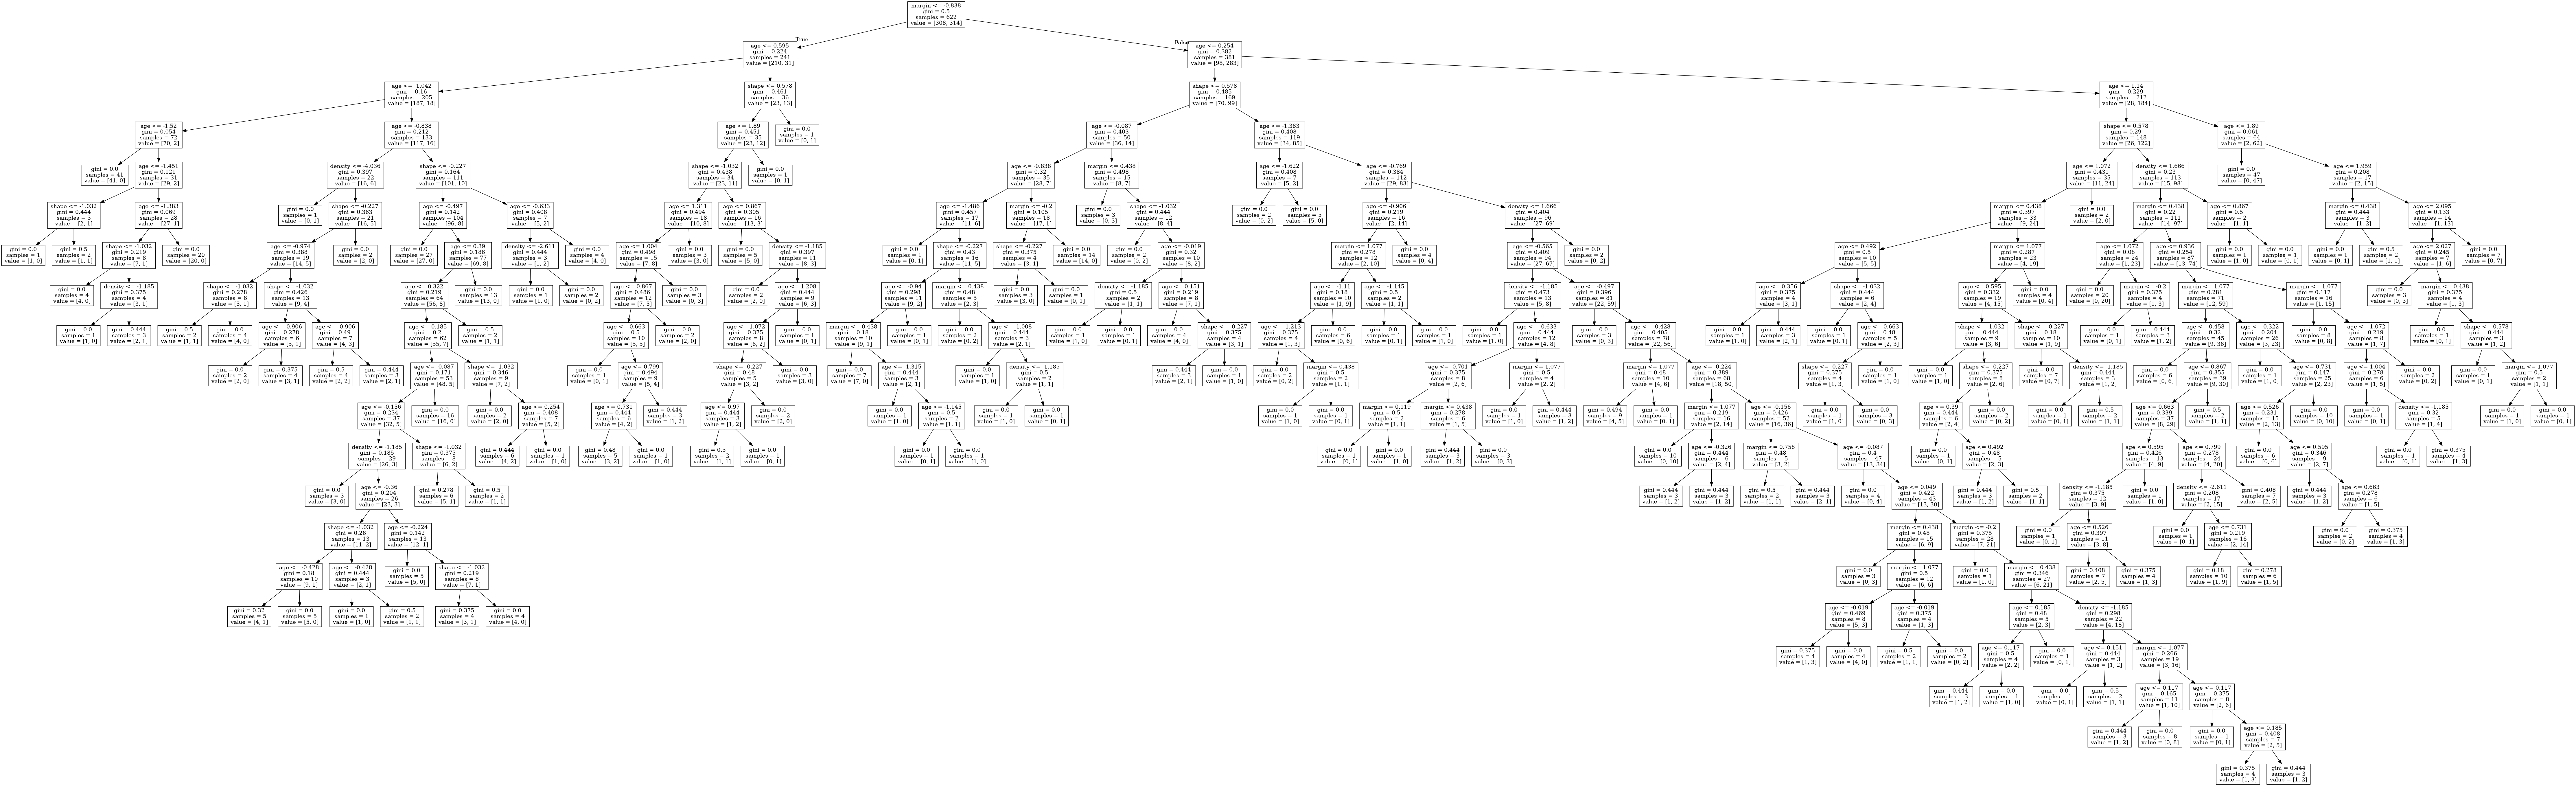

In [13]:
from IPython.display import Image  
from six import StringIO  
from sklearn import tree
from pydotplus import graph_from_dot_data 

dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=feature_names)  
graph = graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

Measure the accuracy of the resulting decision tree model using your test data.

In [14]:
clf.score(testing_inputs, testing_classes)

0.7355769230769231

Now instead of a single train/test split, use K-Fold cross validation to get a better measure of your model's accuracy (K=10). Hint: use model_selection.cross_val_score

In [15]:
from sklearn.model_selection import cross_val_score

clf = DecisionTreeClassifier(random_state=1)

cv_scores = cross_val_score(clf, all_features_scaled, all_classes, cv=10)

cv_scores.mean()

0.7373493975903613

Now try a RandomForestClassifier instead. Does it perform better?

In [16]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10, random_state=1)
cv_scores = cross_val_score(clf, all_features_scaled, all_classes, cv=10)

cv_scores.mean()

0.7421686746987952

## SVM

Next try using svm.SVC with a linear kernel. How does it compare to the decision tree?

In [17]:
from sklearn import svm

C = 1.0
svc = svm.SVC(kernel='linear', C=C)

In [18]:
cv_scores = cross_val_score(svc, all_features_scaled, all_classes, cv=10)

cv_scores.mean()

0.7975903614457832

## KNN
How about K-Nearest-Neighbors? Hint: use neighbors.KNeighborsClassifier - it's a lot easier than implementing KNN from scratch like we did earlier in the course. Start with a K of 10. K is an example of a hyperparameter - a parameter on the model itself which may need to be tuned for best results on your particular data set.

In [19]:
from sklearn import neighbors

clf = neighbors.KNeighborsClassifier(n_neighbors=10)
cv_scores = cross_val_score(clf, all_features_scaled, all_classes, cv=10)

cv_scores.mean()

0.7915662650602409

Choosing K is tricky, so we can't discard KNN until we've tried different values of K. Write a for loop to run KNN with K values ranging from 1 to 50 and see if K makes a substantial difference. Make a note of the best performance you could get out of KNN.

In [20]:
for n in range(1, 50):
    clf = neighbors.KNeighborsClassifier(n_neighbors=n)
    cv_scores = cross_val_score(clf, all_features_scaled, all_classes, cv=10)
    print (n, cv_scores.mean())

1 0.7325301204819278
2 0.6903614457831325
3 0.7542168674698796
4 0.7349397590361446
5 0.7710843373493976
6 0.7686746987951807
7 0.7951807228915662
8 0.7771084337349398
9 0.7903614457831326
10 0.7915662650602409
11 0.7891566265060241
12 0.783132530120482
13 0.7879518072289157
14 0.7867469879518072
15 0.7867469879518072
16 0.7831325301204819
17 0.7783132530120482
18 0.7783132530120482
19 0.7843373493975904
20 0.7855421686746988
21 0.7879518072289156
22 0.7855421686746988
23 0.7783132530120481
24 0.7783132530120482
25 0.7867469879518072
26 0.7855421686746988
27 0.7855421686746988
28 0.7867469879518072
29 0.7855421686746988
30 0.7903614457831325
31 0.7867469879518072
32 0.789156626506024
33 0.7879518072289156
34 0.7867469879518072
35 0.7831325301204819
36 0.7867469879518072
37 0.7843373493975904
38 0.7867469879518072
39 0.7819277108433734
40 0.7843373493975904
41 0.780722891566265
42 0.7819277108433734
43 0.780722891566265
44 0.7819277108433734
45 0.7831325301204819
46 0.7843373493975904
4

## Naive Bayes

Now try naive_bayes.MultinomialNB. How does its accuracy stack up?

In [21]:
from sklearn.naive_bayes import MultinomialNB

scaler = preprocessing.MinMaxScaler()
all_features_minmax = scaler.fit_transform(all_features)

clf = MultinomialNB()
cv_scores = cross_val_score(clf, all_features_minmax, all_classes, cv=10)

cv_scores.mean()

0.7855421686746988

## Revisiting SVM

svm.SVC may perform differently with different kernels. The choice of kernel is an example of a "hyperparamter." Try the rbf, sigmoid, and poly kernels and see what the best-performing kernel is. Do we have a new winner?

In [22]:
C = 1.0
svc = svm.SVC(kernel='rbf', C=C)
cv_scores = cross_val_score(svc, all_features_scaled, all_classes, cv=10)
cv_scores.mean()

0.8012048192771084

In [23]:
C = 1.0
svc = svm.SVC(kernel='sigmoid', C=C)
cv_scores = cross_val_score(svc, all_features_scaled, all_classes, cv=10)
cv_scores.mean()

0.7457831325301204

In [24]:
C = 1.0
svc = svm.SVC(kernel='poly', C=C)
cv_scores = cross_val_score(svc, all_features_scaled, all_classes, cv=10)
cv_scores.mean()

0.7903614457831326

## Logistic Regression

We've tried all these fancy techniques, but fundamentally this is just a binary classification problem. Try Logisitic Regression, which is a simple way to tackling this sort of thing.

In [25]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
cv_scores = cross_val_score(clf, all_features_scaled, all_classes, cv=10)
cv_scores.mean()

0.8072289156626505

## Neural Networks

As a bonus challenge, let's see if an artificial neural network can do even better. You can use Keras to set up a neural network with 1 binary output neuron and see how it performs. Don't be afraid to run a large number of epochs to train the model if necessary.

In [26]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

def create_model():
    model = Sequential()
    #4 feature inputs going into an 6-unit layer (more does not seem to help - in fact you can go down to 4)
    model.add(Dense(6, input_dim=4, kernel_initializer='normal', activation='relu'))
    # "Deep learning" turns out to be unnecessary - this additional hidden layer doesn't help either.
    #model.add(Dense(4, kernel_initializer='normal', activation='relu'))
    # Output layer with a binary classification (benign or malignant)
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model; adam seemed to work best
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [27]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Wrap our Keras model in an estimator compatible with scikit_learn
estimator = KerasClassifier(build_fn=create_model, epochs=100, verbose=0)
# Now we can use scikit_learn's cross_val_score to evaluate this model identically to the others
cv_scores = cross_val_score(estimator, all_features_scaled, all_classes, cv=10)
cv_scores.mean()


0.8012048244476319

## Do we have a winner?

Which model, and which choice of hyperparameters, performed the best? Feel free to share your results!

### The only clear loser is decision trees! Every other algorithm could be tuned to produce comparable results with 79-80% accuracy.

Additional hyperparameter tuning, or different topologies of the multi-level perceptron might make a difference.